In [1]:
from SubspacePipeline import *

In [2]:
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

In [3]:
#Cub-circuits of interest
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

In [4]:
data_path= '/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/unzipped_files/Richards_2017-10-31.tar'
good_cells, brain_regions,br = get_good_cells(data_path)
#Cub-circuits of interest
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

dat=np.load('trial_av_dat.npy')

#Select two brain regions
mos=dat[brain_regions=='MOs']
scs=dat[brain_regions=='SCs']

#Load behavioral data
beh=np.load('beh.npy')
print(beh.shape)
print(mos.shape)
print(scs.shape)

(260, 75)
(122, 75)
(114, 75)


In [5]:
midbrain_circuit=dat[brain_regions=='MRN']
print(midbrain_circuit.shape)
frontal_circuit=dat[brain_regions=='ORB']

(39, 75)


In [6]:
print(frontal_circuit.shape)

(217, 75)


Midbrain explained variance by component: [0.00878768 0.0011227  0.000854   0.00069296 0.00052857]
Frontal brain explained variance by component: [0.08703029 0.00844636 0.00410427 0.0019171  0.00149259 0.00120508
 0.00115971 0.00109238 0.00103365 0.00095815]
Midbrain explained variance cumulative: [0.00878768 0.00991038 0.01076438 0.01145734 0.01198591]
Frontal brain explained variance cumulative: [0.08703029 0.09547665 0.09958092 0.10149802 0.10299062 0.1041957
 0.10535541 0.10644779 0.10748144 0.10843959]
Behavior explained variance by component: [139.32117258  62.03369627  23.5544459   11.26970298   6.5039142 ]
Behavior explained variance cumulative: [139.32117258 201.35486885 224.90931475 236.17901773 242.68293193]


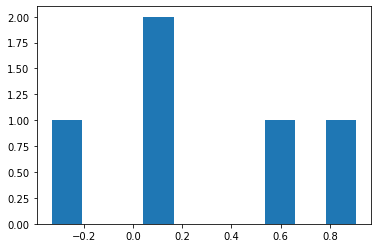

Variance explained: [0.8008114957916644, 0.21517574787935745, -0.11152853781915728, -0.05665507994895913, -0.229751518788176]
Dimensions that best explain variance on the test set: (array([0]),)
0
corr coef, dim=0: 0.9020522612711391


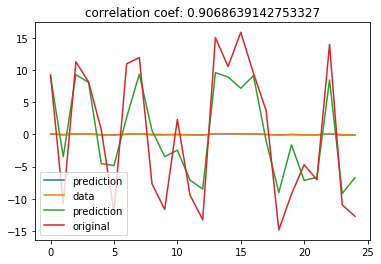

0
corr coef, dim=1: 0.7778469556447559


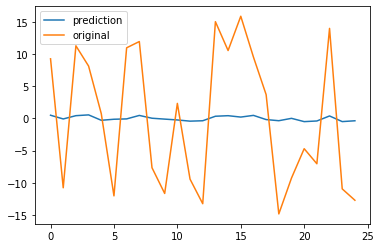

1
corr coef, dim=2: 0.6574925558466774


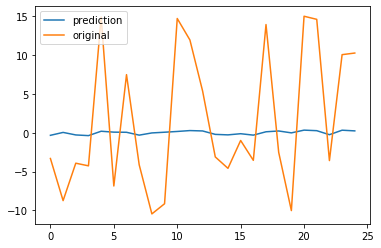

2
corr coef, dim=3: 0.3709846152207059


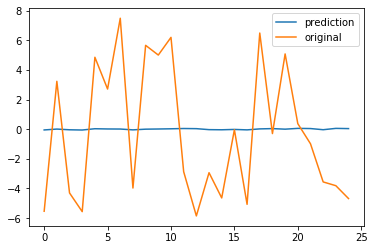

3
corr coef, dim=4: -0.12816005594802654


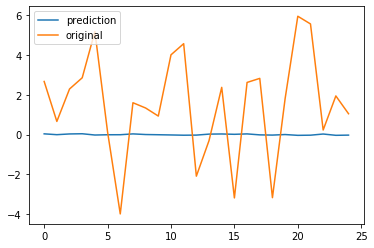

corr coef, dim=0: 0.729522477352525


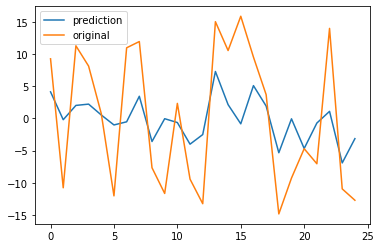

corr coef, dim=1: 0.6262239257383003


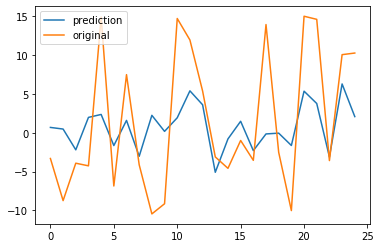

corr coef, dim=2: -0.01702309062763181


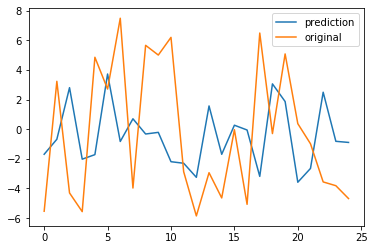

In [ ]:
def communication_subspace_pipeline(midbrain_circuit,frontal_circuit,beh):
    #Test train split
    front_train, front_test, mid_train,mid_test,beh_train,beh_test=train_test_split(frontal_circuit.T,midbrain_circuit.T, beh.T,test_size=0.33, random_state=42)
    #PCA
    
    pca_mid=PCA(n_components=5)
    pca_frontal=PCA(n_components=10)
    pca_beh=PCA(n_components=5)

    pcs_mid=pca_mid.fit_transform(mid_train)
    pcs_front=pca_frontal.fit_transform(front_train)
    pcs_beh=pca_beh.fit_transform(beh_train)

    pcs_mid_test=pca_mid.transform(mid_test)
    pcs_front_test=pca_frontal.transform(front_test)
    pcs_beh_test=pca_beh.transform(beh_test)

    print('Midbrain explained variance by component:',pca_mid.explained_variance_)
    print('Frontal brain explained variance by component:',pca_frontal.explained_variance_)
    print('Midbrain explained variance cumulative:', np.cumsum(pca_mid.explained_variance_))
    print('Frontal brain explained variance cumulative:',np.cumsum(pca_frontal.explained_variance_))
    print('Behavior explained variance by component:',pca_beh.explained_variance_)
    print('Behavior explained variance cumulative:', np.cumsum(pca_beh.explained_variance_))
    
    #Ridge regression from front pcs to midbrain pcs
    from_front_to_mid_reg=ridge_regression(pcs_front,pcs_mid,pcs_front_test,pcs_mid_test,regularization_parameter=1)
    
    # Extract pc dimensions from the PCA transformed frontal activity on test timepoints that predict PC's in the midbrain on test
    var_exp=[]
    for j in range(0,pcs_mid_test.shape[1]):
        prediction=from_front_to_mid_reg.coef_[j,:]@(pcs_front_test.T)
        var_exp.append(variance_explained(pcs_mid_test[:,j],prediction))

    print('Variance explained:', var_exp)
    predictive_dimensions=np.where(np.array(var_exp)>0.5)
    print('Dimensions that best explain variance on the test set:', predictive_dimensions)
    unpredictive_dimensions=np.where(np.array(var_exp)<=0.5)
    
    #Ridge behavior
    #ridge_behavior(from_front_to_mid_reg,pcs_front,pcs_front_test,pcs_beh,pcs_beh_test,pcs_mid_test,predictive_dimensions)
    #ridge_behavior(from_front_to_mid_reg,pca_frontal,pcs_front,pcs_front_test,pcs_beh,pcs_beh_test,pcs_mid_test,predictive_dimensions)
    ridge_behavior(from_front_to_mid_reg,pca_frontal,pcs_front,front_test,pcs_front_test,pcs_beh,pcs_beh_test,pcs_mid_test,predictive_dimensions)
    ridge_behavior(from_front_to_mid_reg,pca_frontal,pcs_front,front_test,pcs_front_test,pcs_beh,pcs_beh_test,pcs_mid_test,unpredictive_dimensions)
    
    #Nullspace
    coefficients=from_front_to_mid_reg.coef_
    null_coefficients=null_space(coefficients)
    projection_onto_nullspace_train=null_coefficients.T@pcs_front.T
    projection_onto_nullspace_test=null_coefficients.T@pcs_front_test.T
    #communication_subspace_pipeline(midbrain_circuit,frontal_circuit,beh)

    ridge_nullspace(projection_onto_nullspace_train,projection_onto_nullspace_test,pcs_beh,pcs_beh_test)

communication_subspace_pipeline(midbrain_circuit,frontal_circuit,beh)

In [8]:
#ridge_behavior(from_front_to_mid_reg,pcs_front,pcs_front_test,pcs_beh,pcs_beh_test,pcs_mid_test,predictive_dimensions)